In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install matplotlib

In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
# %load preprocess.py
import numpy as np

def modifyCSV(tx, invalid=True, standardize=True):
    """ Modify the data to remove invalid values, -999, and/or standardize the data.

    Args:
        tx: Data to be modified
        invalid: Replace invalid values with mean of valid values
        standardize: Standardize values
    Return:
        Return modified data
    """
    res = tx.copy()
    if (invalid):
        res = invalidToMean(res)
    if (standardize):
        res = standardizeValues(res)
    return res
    

def standardizeValues(tx):
    """ Standardize values. """
    res = tx.copy()
    M,N = tx.shape
    means = np.mean(res, axis=0)
    std_dev = np.std(res, axis=0)
    std_tx = np.divide(np.subtract(res, means),std_dev)
    return std_tx


def standardize(x):
    """ Standardize the original data set.

    Args:
        x: Data set.
    Return:
        Standardized data set.
    """
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x


def invalidToMean(tx):
    """ Change all -999 values with the mean of valid values of same column. """
    _,N = tx.shape
    res = tx.copy()
    tmp_tx = tx.copy()

    # Set all -999 values to NaN
    tmp_tx[tx == -999] = np.nan

    # Compute mean ignoring NaN values
    means = np.nanmean(tmp_tx, axis=0)
    
    for i in range(N):
        # For each column replace values -999 with the mean of valid values
        res[:,i][res[:,i] == -999] = means[i]

    return res

def displayFeatures(tx):
    M, N = tx.shape
    ptX = modifyCSV(tx)
    for i in range(2, N):
        ax = plt.subplot()
        plt.scatter(np.arange(M), ptX[:,i])
        plt.title("Feature "+str(i-1))
        plt.show()

def computeCorrelation(tx):
    M, N = tx.shape
    ptX = modifyCSV(tx)
    for i in range(2, N-1):
        for j in range(i+1, N):
            mean_x = np.mean(ptX[:,i])
            mean_y = np.mean(ptX[:,j])
            r = np.divide(np.sum(np.multiply(np.subtract(ptX[:,i], mean_x), np.subtract(ptX[:,j], mean_y))), np.multiply(np.sqrt(np.sum(np.power(np.subtract(ptX[:,i], mean_x),2))), np.sqrt(np.sum(np.power(np.subtract(ptX[:,j], mean_y),2)))))
            if (r > 0.9):
                print("Correlation between "+str(i-1)+" and "+str(j-1)+" :")
                print(r)
            if (r < -0.9):
                print("Correlation between "+str(i-1)+" and "+str(j-1)+" :")
                print(r)


In [4]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv' # TODO: download train data and supply path here 
y, otX, ids = load_csv_data(DATA_TRAIN_PATH)

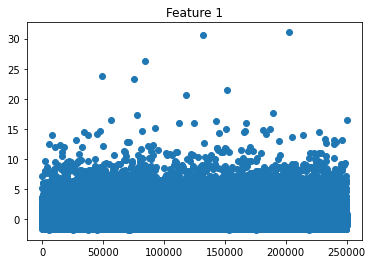

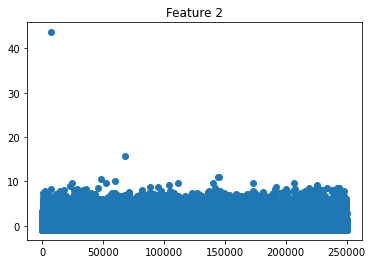

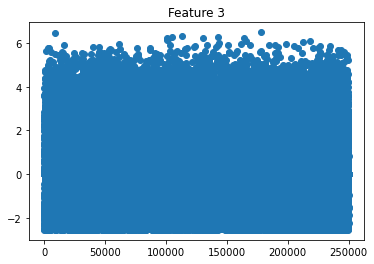

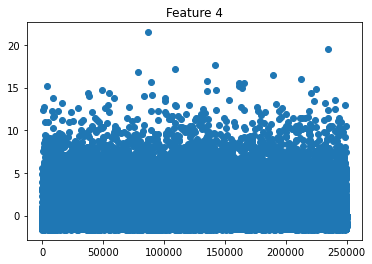

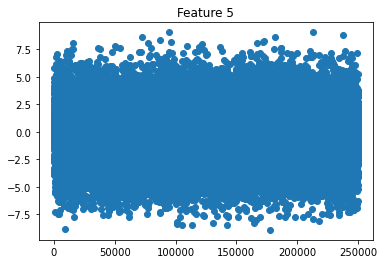

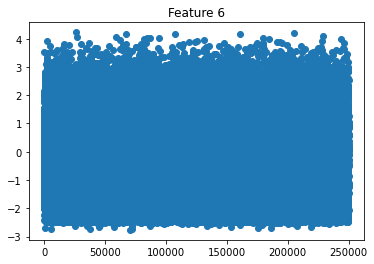

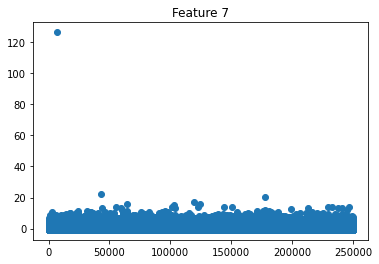

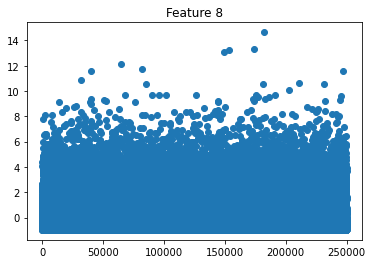

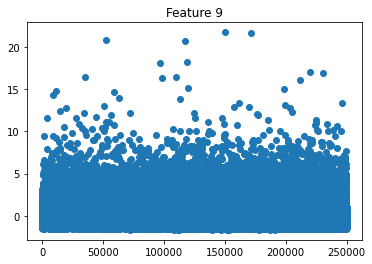

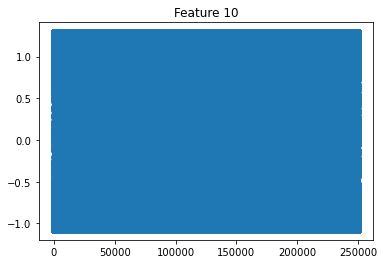

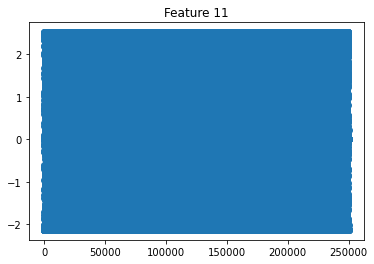

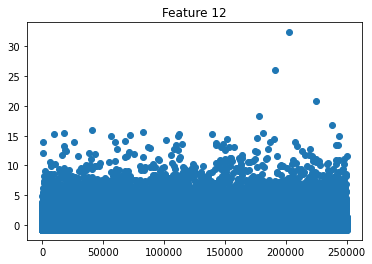

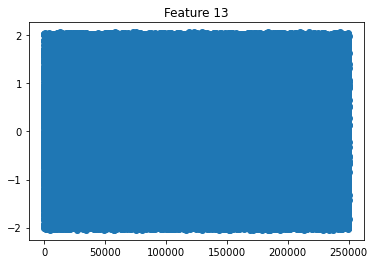

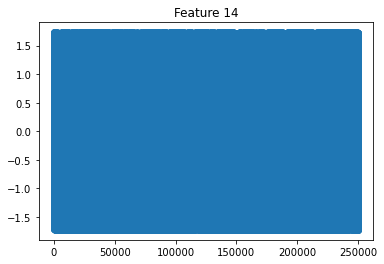

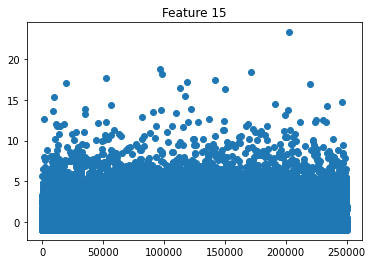

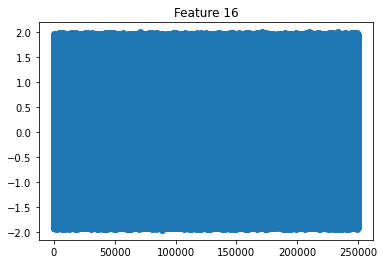

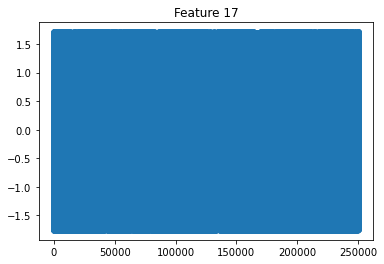

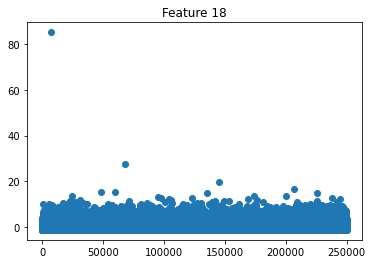

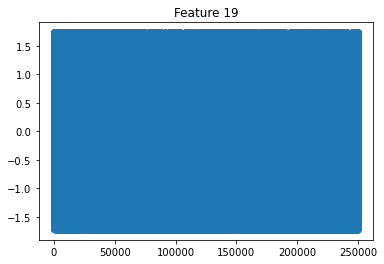

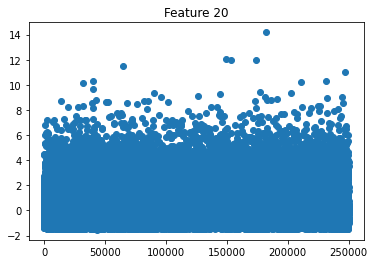

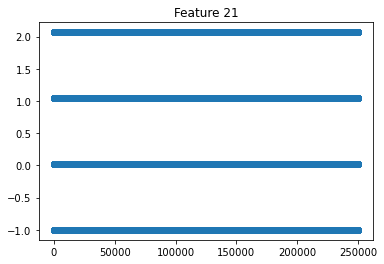

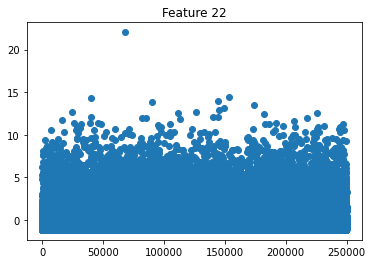

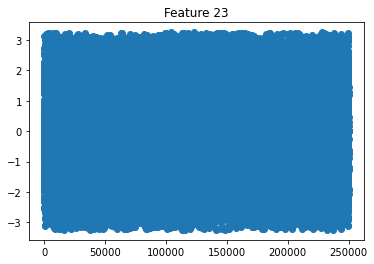

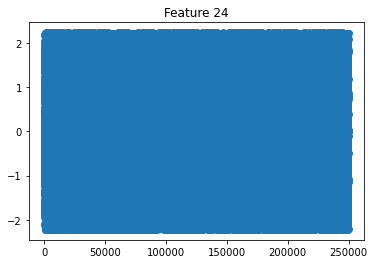

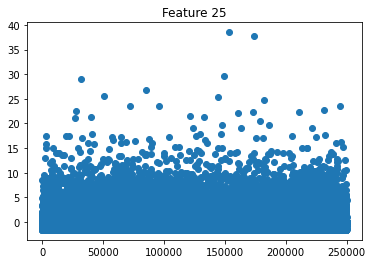

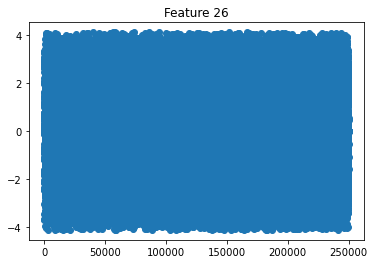

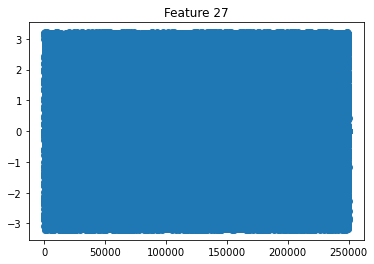

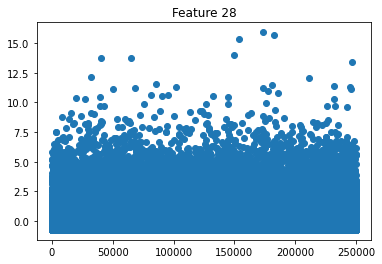

In [5]:
displayFeatures(otX)

In [6]:
computeCorrelation(otX)

Correlation between 8 and 20 :
0.9044814595684976
Correlation between 8 and 28 :
0.965628388916399


In [7]:
tX = modifyCSV(otX)
M,N = tX.shape
# Remove features 28 due to correlation
tX = np.delete(tX, 29, axis=1)
# Remove feature 21 due to it being categorical
tX = np.delete(tX, 22, axis=1)
# Remove features 20 due to correlation
tX = np.delete(tX, 21, axis=1)
# Augment features
tX = np.concatenate((np.ones((M,1)),tX, np.sin(tX), np.cos(tX)), axis=1)

In [8]:
# %load proj1_helpers.py
"""some helper functions for project 1."""
import csv
import numpy as np


def load_csv_data(data_path, sub_sample=False):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1
    
    # sub-sample
    if sub_sample:
        yb = yb[::50]
        input_data = input_data[::50]
        ids = ids[::50]

    return yb, input_data, ids


def predict_labels(weights, data):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    y_pred[np.where(y_pred <= 0)] = -1
    y_pred[np.where(y_pred > 0)] = 1
    
    return y_pred


def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in csv format for submission to kaggle
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})


In [9]:
# %load implementations.py
import numpy as np
from numpy.linalg import inv
from tqdm import tqdm

def mini_batch(y, tx, size, num):
    """ Generate random batches from the given data.
    
    Args:
        y: Class labels.
        tx: Features as a NxM matrix.
        size: Size of batches.
        num: Number of batches.
    Yields:
        labels and data for a batch.

    Usage:
        To iterate through all batches use the following for loop :

        for b_y, b_tx in mini_batch(y, tx, size, num):
    """
    N = len(y)
    # Get random indices
    batch_ind = np.random.permutation(np.arange(N))
    for batch_id in range(num):
        s_id = int(batch_id*size)
        e_id = int(s_id+size)
        ids = batch_ind[s_id:e_id]
        yield y[ids], tx[ids]

def k_fold_batch(y, tx, k):
    """ Generate batches for k-fold.

    Args:
        y: Class labels.
        tx: Features as a NxM matrix.
        k: Number of folds.
    Return:
        y_train: k-1 batches of labels for training.
        tx_train: k-1 batches of data for training.
        y_test: 1 batch of labels for testing.
        tx: 1 batch of data for testing
    """
    N = len(y)
    if N%k != 0:
        print("K-fold error: Size of tX must be multiple of k.")
        return
    batch_size = int(N/k)
    # Get random indices
    batch_ind = np.arange(N)
    y_train = []
    tx_train = []
    for batch_id in range(k-1):
        s_id = int(batch_id*batch_size)
        e_id = int(s_id+batch_size)
        y_train.append(y[s_id:e_id].copy())
        tx_train.append(tx[s_id:e_id].copy())
    y_test = y[N-batch_size:N]
    tx_test = tx[N-batch_size:N]
    return y_train, tx_train, y_test, tx_test

def mae_loss(y, tx, w):
    """ Compute the MAE loss. """
    e = y - tx.dot(w)
    return np.sum(np.abs(e))/(2*len(y))


def mse_loss(y, tx, w):
    """ Compute the MSE loss. """
    e = y - tx.dot(w)
    return np.sum(np.square(e))/(2*len(y))

def cross_validate_ridge_regression(y, tx, k, l_st, l_en, l_space, show=False):
    """ K-fold cross-validation for selecting lambda for ridge regression.
    
    Args:
        y: class labels.
        tx: Features as a NxM matrix.
        k: Number of folds.
        l_st: Start of logspace for lambdas to test.
        l_en: End of logspace for lambdas to test.
        l_space: Number of lambdas to test in the logspace.

    Returns:
        The lambda with the lowest mean error for cross-validation with k folds.
    """
    size_batches = tx/k
    y_train_set, tx_train_set, y_test, tx_test = k_fold_batch(y, tx, k)
    min_loss = 999999999999
    best_l = 0
    tested_loss = []
    tested_lambda = []
    for l in tqdm(np.logspace(l_st, l_en, num=l_space)):
        tmp_loss = []
        for i in range(len(y_train_set)):
            b_y = y_train_set[i]
            b_tx = tx_train_set[i]
            w, _ = ridge_regression(b_y, b_tx,l)
            tmp_loss.append(mse_loss(y_test, tx_test, w))
        mean_loss = np.mean(tmp_loss)
        # Loss and lambda used for plot.
        tested_loss.append(mean_loss)
        tested_lambda.append(l)
        if mean_loss < min_loss:
            min_loss = mean_loss
            best_l = l
    if show:
        plt.semilogx(tested_lambda, tested_loss, "*r")
    return best_l

def cross_validate_reg_logistic_regression(y, tx, initial_w, max_iters, gamma, k, l_st, l_en, l_space, show=False):
    """ K-fold cross-validation for selecting lambda for regularized logistic regression.
    
    Args:
        y: class labels.
        tx: Features as a NxM matrix.
        initial_w: Initial weights vector.
        max_iters: Number of steps.
        gamma: Step size.
        k: Number of folds.
        l_st: Start of logspace for lambdas to test.
        l_en: End of logspace for lambdas to test.
        l_space: Number of lambdas to test in the logspace.

    Returns:
        The lambda with the lowest mean error for cross-validation with k folds.
    """
    size_batches = tx/k
    y_train_set, tx_train_set, y_test, tx_test = k_fold_batch(y, tx, k)
    min_loss = 999999999999
    best_l = 0
    tested_loss = []
    tested_lambda = []
    y_log = y.copy()
    y_log[y_log == -1] = 0
    w = initial_w
    for l in tqdm(np.logspace(l_st, l_en, num=l_space)):
        tmp_loss = []
        for i in range(len(y_train_set)):
            b_y = y_train_set[i]
            b_tx = tx_train_set[i]
            w, reg_loss = reg_logistic_regression(b_y, b_tx, l, initial_w, max_iters, gamma)
            tmp_loss.append(reg_loss)
        mean_loss = np.mean(tmp_loss)
        # Loss and lambda used for plot.
        tested_loss.append(mean_loss)
        tested_lambda.append(l)
        if mean_loss < min_loss:
            min_loss = mean_loss
            best_l = l
    if show:
        plt.semilogx(tested_lambda, tested_loss, "*r")
    return best_l

""" Requested ML methods. """
def least_square_GD(y, tx, initial_w, max_iters, gamma):
    """ Linear regression using gradient descent. """
    w = initial_w
    for i in tqdm(range(max_iters)):
        # Compute error vector
        e = y-tx.dot(w)
        # Compute gradient
        grad = (-1/len(y)) * tx.transpose().dot(e)
        # Compute w(t+1)
        w = w - gamma*grad
        # Compute loss
        loss = mse_loss(y, tx, w)
    return w, loss

def least_square_SGD(y, tx, initial_w, max_iters, gamma):
    """ Linear regression using stochastic gradient descent. """
    w = initial_w
    for i in tqdm(range(max_iters)):
        size = len(y)/20
        grad = 0
        num = 5
        for b_y, b_tx in mini_batch(y, tx, size, num):
            e = b_y-b_tx.dot(w)
            grad += (-1/len(b_y)) * b_tx.transpose().dot(e)
        w = w - gamma*grad
        loss = mse_loss(y, tx, w)
    return w, loss

def least_squares(y, tx):
    """ Least squares using normal equations. """
    w = inv(tx.transpose().dot(tx)).dot(tx.transpose()).dot(y)
    loss = mse_loss(y, tx, w)
    return w, loss

def ridge_regression(y, tx, lambda_):
    """ Ridge regression using normal equations. """
    M, N = tx.shape
    w = inv(np.add(tx.transpose().dot(tx), 2*M*lambda_ * np.identity(N))).dot(tx.transpose()).dot(y)
    loss = mse_loss(y, tx, w)
    return w, loss

def logistic_function(z):
    """ The logistic function sigma. """
    return np.exp(z)/(1+np.exp(z))

def logistic_loss(y, tx, w):
    M, N = tx.shape
    return (1/M)*np.sum(np.subtract(np.multiply(-y, np.log(logistic_function((tx.dot(w)))))), np.multiply(np.subtract(1, y), np.log(np.subtract(1, logistic_function(tx.dot(w))))))

def logistic_regularized_loss(y, tx, w, lambda_):
    M, N = tx.shape
    return (1/M)*np.sum(np.subtract(np.multiply(-y, np.log(logistic_function((tx.dot(w)))))), np.multiply(np.subtract(1, y), np.log(np.subtract(1, logistic_function(tx.dot(w)))))) + (lambda_/(2*M))*np.sum(np.power(w, 2))

def logistic_regression(y, tx, initial_w, max_iters, gamma):
    """ Logistic regression using gradient descent or SGD. """
    y_log = y.copy()
    y_log[y_log == -1] = 0
    w = initial_w
    M, N = tx.shape
    for i in range(max_iters):
        grad = np.divide(tx.transpose().dot(np.subtract(logistic_function(tx.dot(w)), y_log)), M)
        w = w - gamma*grad
    loss = logistic_loss(y, tx, w)
    return w, loss

def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    """ Regularized logistic regression using gradient descent or SGD. """
    y_log = y.copy()
    y_log[y_log == -1] = 0
    w = initial_w
    M, N = tx.shape
    for i in range(max_iters):
        grad = np.divide(tx.transpose().dot(logistic_function(tx.dot(w))-y_log) + lambda_ * np.sum(np.linalg.norm(w)), M)
        w = w - gamma*grad
    loss = logistic_regularized_loss(y, tx, w, lambda_)
    return w, loss


In [ ]:
initial_w = np.zeros(tX.shape[1])
initial_w[0] = 1
max_iters = 10000
gamma = 1e-8

weights, loss = least_square_SGD(y, tX, initial_w, max_iters, gamma)
print(loss)
outpath = 'output/LS/SGD_g1e-8_100000.csv'

In [ ]:
initial_w = np.zeros(tX.shape[1])
initial_w[0] = 1
max_iters = 100000
gamma = 1e-8

weights, loss = least_square_GD(y, tX, initial_w, max_iters, gamma)
outpath = 'output/LS/GD_g1e-8_100000.csv'

In [11]:
k = 10
l_st = -3.9
l_en = -3.6
l_space = 300

lambda_ = cross_validate_ridge_regression(y, tX, k, l_st, l_en, l_space)
weights, loss = ridge_regression(y, tX, lambda_)
outpath = 'output/RR/'+str(k)+'_fold_lambda_'+str(lambda_)+'.csv'

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:44<00:00,  6.72it/s]


In [ ]:
initial_w = np.zeros(tX.shape[1])
max_iters = 2000
gamma = 1e-6
k = 10
l_st = -5
l_en = 5
l_space = 100

lambda_ = cross_validate_reg_logistic_regression(y, tX, initial_w, max_iters, gamma, k, l_st, l_en, l_space)
weights, loss = reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma)
outpath = 'output/RR/reg_log_'+str(k)+'_fold_lambda_'+str(lambda_)+'.csv'

In [ ]:
initial_w = np.zeros(tX.shape[1])
max_iters = 20000
gamma = 1e-8
k = 10
l_st = -7
l_en = 1
l_space = 100
reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma)
#logistic_regression(y, tX, initial_w, max_iters, gamma)

## Generate predictions and save ouput in csv format for submission:

In [10]:
import numpy as np


def basic_metrics(y, y_pred):
    TP = np.sum(np.logical_and(y_pred == 1, y == 1))
    TN = np.sum(np.logical_and(y_pred == -1, y == -1))
    FP = np.sum(np.logical_and(y_pred == 1, y == -1))
    FN = np.sum(np.logical_and(y_pred == -1, y == 1))
    return TP, TN, FP, FN


def precision(y, y_pred):
    TP, TN, FP, FN = basic_metrics(y, y_pred)
    return TP / (TP + FP)


def TPR(y, y_pred):
    TP, TN, FP, FN = basic_metrics(y, y_pred)
    return TP / (TP + FN)


def FPR(y, y_pred):
    TP, TN, FP, FN = basic_metrics(y, y_pred)
    return FP / (FP + TN)


def accuracy(y, y_pred):
    TP, TN, FP, FN = basic_metrics(y, y_pred)
    return (TP + TN) / (TP + TN + FP + FN)


def F1(y, y_pred):
    p = precision(y, y_pred)
    r = TPR(y, y_pred)
    return 2 * (p * r) / (p + r)


def metrics(y, y_pred):
    return F1(y, y_pred), accuracy(y, y_pred)


In [20]:
DATA_TEST_PATH = 'data/test.csv'
_, otX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test = modifyCSV(otX_test)
M,N = tX_test.shape
# Remove features 28 due to correlation
tX_test = np.delete(tX_test, 29, axis=1)
# Remove feature 21 due to it being categorical
tX_test = np.delete(tX_test, 22, axis=1)
# Remove features 20 due to correlation
tX_test = np.delete(tX_test, 21, axis=1)
# Augment features
tX_test = np.concatenate((np.ones((M,1)),tX_test, np.sin(tX_test), np.cos(tX_test)), axis=1)

In [21]:
y_pred = predict_labels(weights, tX_test)

In [22]:
# Metrics
F1, accuracy = metrics(y, y_pred)
print("F1-score: {}, accuracy: {}.".format(F1, accuracy))

TypeError: 'numpy.float64' object is not callable

In [23]:
OUTPUT_PATH = "./data/output_jupyter.csv"
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)